In [1]:
%config InlineBackend.figure_formats = ['svg']

import quimb as qu
import quimb.tensor as qtn
from skopt import Optimizer
from skopt.plots import plot_convergence, plot_objective
import cotengra as ctg

import json
import yfinance as yf
from coskweness_cokurtosis import coskewness, cokurtosis
from portfolio_hubo_qaoa_light import HigherOrderPortfolioQAOA
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import sample_cov

/u/31/uotilav2/unix/Desktop/quantum-portfolio/myenv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:57: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/u/31/uotilav2/unix/Desktop/quantum-portfolio/myenv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:39: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/u/31/uotilav2/unix/Desktop/quantum-portfolio/myenv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:76: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


In [2]:
experiments = None
with open("experiments_data.json", "r") as f:
    experiments = list(json.load(f)["data"])

experiment = experiments[40]
stocks = experiment["stocks"]
start = experiment["start"]
end = experiment["end"]
risk_aversion = 0.1
max_qubits = 15
budget = experiment["budget"]
print(f"Budget: {budget}")

data = yf.download(stocks, start=start, end=end)
prices_now = data["Close"].iloc[-1]
returns = data["Close"].pct_change(fill_method=None).dropna(how="any")
stocks = returns.columns
numpy_returns = returns.to_numpy()

expected_returns = mean_historical_return(returns, returns_data=True).to_numpy()
covariance_matrix = sample_cov(returns, returns_data=True).to_numpy()
coskewness_tensor = coskewness(numpy_returns)
cokurtosis_tensor = cokurtosis(numpy_returns)

portfolio_hubo = HigherOrderPortfolioQAOA(stocks=stocks,
                                        prices_now=prices_now,
                                        expected_returns=expected_returns, 
                                        covariance_matrix=covariance_matrix,
                                        budget=budget,
                                        max_qubits=max_qubits,
                                        coskewness_tensor=coskewness_tensor, 
                                        cokurtosis_tensor=cokurtosis_tensor,
                                        log_encoding=True,
                                        risk_aversion=risk_aversion,
                                        strict_budget_constraint=False)

Budget: 483
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  5 of 5 completed


Number of qubits for asset AXP: 1
Number of qubits for asset DIS: 3
Number of qubits for asset DOW: 4
Number of qubits for asset VZ: 4
Number of qubits for asset WMT: 3
Total number of qubits:  15


In [3]:
opt = ctg.ReusableHyperOptimizer(
    methods=['greedy'],
    reconf_opts={},
    max_repeats=32,
    max_time="rate:1e6",
    parallel=True,
    # use the following for persistently cached paths
    # directory=True,
)

In [4]:
import itertools
from quimb.tensor import Circuit

def gates_qaoa(
    terms,
    depth,
    gammas,
    betas,
):
    n = max(itertools.chain.from_iterable(terms)) + 1

    gates = []

    # layer of hadamards to get into plus state
    for i in range(n):
        gates.append((0, "h", i))

    for d in range(depth):
        for term, coef in terms.items():
            if len(term) == 1:
                i, = term
                gates.append((d, "rz", coef * gammas[d], i))
            elif len(term) == 2:
                i, j = term
                gates.append((d, "rzz", coef * gammas[d], i, j))
            elif len(term) == 3:
                i, j, k = term
                gates.append((d, "cnot", i, j))
                gates.append((d, "cnot", j, k))

                gates.append((d, "rz", coef * gammas[d], k))

                gates.append((d, "cnot", j, k))
                gates.append((d, "cnot", i, j))
            
            elif len(term) == 4:
                i, j, k, l = term
                gates.append((d, "cnot", i, j))
                gates.append((d, "cnot", j, k))
                gates.append((d, "cnot", k, l))

                gates.append((d, "rz", coef * gammas[d], l))

                gates.append((d, "cnot", k, l))
                gates.append((d, "cnot", j, k))
                gates.append((d, "cnot", i, j))

        #for (i, j), wij in terms.items():
        #    gates.append((d, "rzz", wij * gammas[d], i, j))

        for i in range(n):
            gates.append((d, "rx", -betas[d] * 2, i))

    return gates


def circ_qaoa(
    terms,
    depth,
    gammas,
    betas,
    **circuit_opts,
):

    circuit_opts.setdefault("gate_opts", {})
    circuit_opts["gate_opts"].setdefault("contract", False)

    n = max(itertools.chain.from_iterable(terms)) + 1

    print(type(terms))
    gates = gates_qaoa(terms, depth, gammas, betas)

    circ = Circuit(n, **circuit_opts)
    circ.apply_gates(gates)

    return circ

In [5]:
terms = portfolio_hubo.get_cost_hubo_bin()
print(f"Number of terms: {len(terms)}")
for term in terms:
    print(term)
    break

stocks_to_int = {stock: i for i, stock in enumerate(stocks)}

# Replace the stock names with integers
terms_int = {}
for term in terms:
    new_term = []
    for stock, coefficient in term:
        new_term.append((stocks_to_int[stock], coefficient))
    terms_int[tuple(new_term)] = terms[term]
terms = terms_int

for term in terms:
    print(len(term), terms[term])
    break

variables = [var[0] for var in terms.keys() if len(var) == 1]
print(f"Number of variables: {len(variables)}")
print(variables[0])
tuples_to_int = {term: i for i, term in enumerate(variables)}

# Replace the tuples with integers
terms_int = {}
for term in terms:
    new_term = []
    for t in term:
        new_term.append(tuples_to_int[t])
    terms_int[tuple(new_term)] = terms[term]

terms = terms_int

for term in terms:
    print(term, terms[term])
    break

print(type(terms))

Number of terms: 54240
(('AXP', 0),)
1 -286026.85330677475
Number of variables: 15
(0, 0)
(0,) -286026.85330677475
<class 'dict'>


In [6]:
p = 1
gammas = qu.randn(p)
betas = qu.randn(p)
circ_ex = circ_qaoa(terms, p, gammas, betas)

<class 'dict'>


In [ ]:
circ_ex.psi.draw(color=['PSI0', 'H', 'RZZ', 'RX', 'RZ', 'CNOT'], figsize=(10, 10))

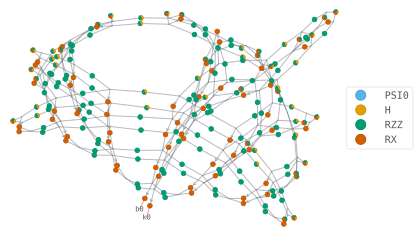

In [ ]:
circ_ex.get_rdm_lightcone_simplified([0]).draw(color=['PSI0', 'H', 'RZZ', 'RX', 'RZ', 'CNOT'], highlight_inds=['k0', 'b0'])

In [ ]:
import tqdm

ZZ = qu.pauli('Z') & qu.pauli('Z')

local_exp_rehs = [
    circ_ex.local_expectation_rehearse(weight * ZZ, edge, optimize=opt)
    for edge, weight in tqdm.tqdm(list(terms.items()))
]

  0%|          | 0/81 [00:00<?, ?it/s]/u/31/uotilav2/unix/Desktop/quantum-portfolio/myenv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:57: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/u/31/uotilav2/unix/Desktop/quantum-portfolio/myenv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:39: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/u/31/uotilav2/unix/Desktop/quantum-portfolio/myenv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:76: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/u/31/uotilav2/unix/Desktop/quantum-portfolio/myenv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:57: UserWarning: Couldn't find `optuna`, `cmaes`, or `n

In [ ]:
import matplotlib.pyplot as plt

with plt.style.context(qu.NEUTRAL_STYLE):
    fig, ax1 = plt.subplots()
    ax1.plot([rehs['W'] for rehs in local_exp_rehs], color='green')
    ax1.set_ylabel('contraction width, $W$, [log2]', color='green')
    ax1.tick_params(axis='y', labelcolor='green')

    ax2 = ax1.twinx()
    ax2.plot([rehs['C'] for rehs in local_exp_rehs], color='orange')
    ax2.set_ylabel('contraction cost, $C$, [log10]', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

In [ ]:
def energy(x):
    p = len(x) // 2
    gammas = x[:p]
    betas = x[p:]
    circ = qtn.circ_qaoa(terms, p, gammas, betas)

    ZZ = qu.pauli('Z') & qu.pauli('Z')

    ens = [
        circ.local_expectation(weight * ZZ, edge, optimize=opt, backend="jax")
        for edge, weight in terms.items()
    ]

    return sum(ens).real

In [ ]:
eps = 1e-6
bounds = (
    [(0.0        + eps, qu.pi / 2 - eps)] * p +
    [(-qu.pi / 4 + eps, qu.pi / 4 - eps)] * p
)

bopt = Optimizer(bounds)

In [ ]:
for i in tqdm.trange(100):
    x = bopt.ask()
    res = bopt.tell(x, energy(x))

In [ ]:
with plt.style.context(qu.NEUTRAL_STYLE):
    plot_convergence(res);

In [ ]:
with plt.style.context(qu.NEUTRAL_STYLE):
    plot_objective(
        res,
        cmap='RdYlBu_r',
        dimensions=[f'$\\gamma_{i}$' for i in range(p)] + [f'$\\beta_{i}$' for i in range(p)],
    );